In [1]:
import zipfile
with zipfile.ZipFile('/content/archive (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:21:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 95.01%

Confusion Matrix:
 [[ 886    0    8   27   16   18    3]
 [   4  104    0    1    0    2    0]
 [  10    0  945   26   21   16    6]
 [   6    0    3 1739   10   11    5]
 [   5    0    6   21 1180   20    1]
 [  17    0    9   39   18 1163    1]
 [   2    0    4   15    2    5  803]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.95      0.92      0.94       958
     disgust       1.00      0.94      0.97       111
        fear       0.97      0.92      0.95      1024
       happy       0.93      0.98      0.95      1774
     neutral       0.95      0.96      0.95      1233
         sad       0.94      0.93      0.94      1247
    surprise       0.98      0.97      0.97       831

    accuracy                           0.95      7178
   macro avg       0.96      0.95      0.95      7178
weighted avg       0.95      0.95      0.95      7178



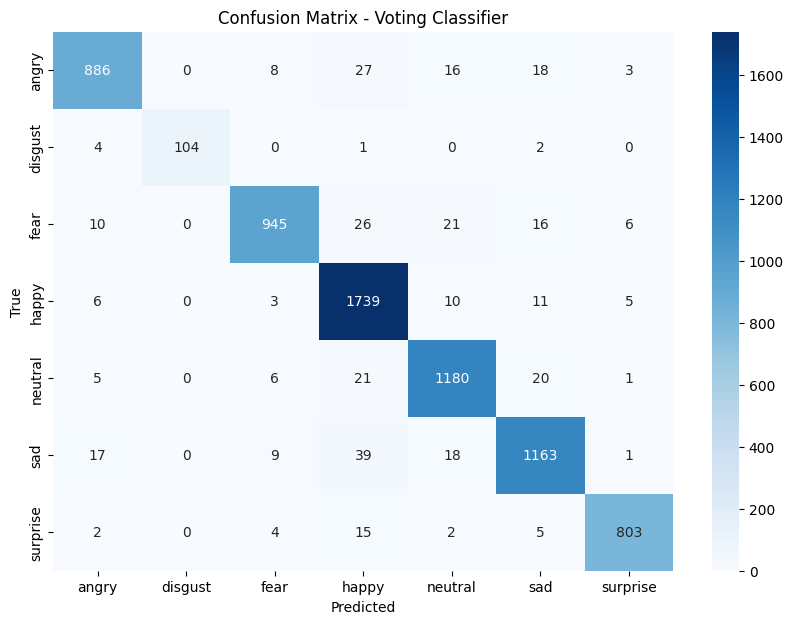

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:24:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:34:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:37:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Scores: [0.49106129 0.48680477 0.48808173 0.4949624  0.49425287]
Mean Cross-Validation Score: 49.10%


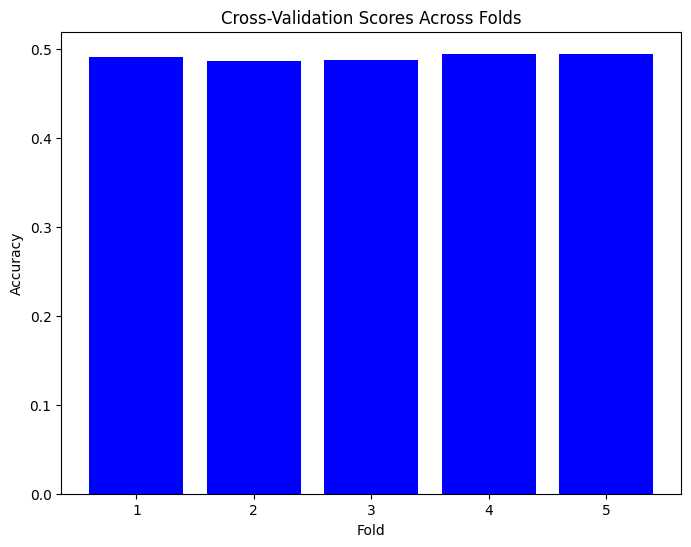

The predicted emotion for the uploaded image is: sad


In [4]:
# Import required libraries
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split

# Load and preprocess dataset
def load_images_for_voting(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (48, 48))  # Resize to 48x48
            if img is not None:
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                images.append(hog_features)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
train_dir = '/content/train'
test_dir = '/content/test'
X_train, y_train = load_images_for_voting(train_dir)
X_test, y_test = load_images_for_voting(test_dir)

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=150)  # Adjust based on your data and computational resources
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define individual models
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define Voting Classifier (soft voting)
voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train_pca, y_train_encoded)

# Make predictions on test set
y_pred_voting = voting_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test_encoded, y_pred_voting)
report = classification_report(y_test_encoded, y_pred_voting, target_names=label_encoder.classes_)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(voting_clf, X_train_pca, y_train_encoded, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean() * 100:.2f}%")

# Plot cross-validation scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='blue')
plt.title('Cross-Validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

# Function to test and predict a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (48, 48))  # Resize to 48x48
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features_scaled = scaler.transform([hog_features])  # Scale the features
    hog_features_pca = pca.transform(hog_features_scaled)  # Transform with PCA
    return hog_features_pca

def predict_emotion(image_path, model):
    img_features = preprocess_image(image_path)
    predicted_label = model.predict(img_features)
    return label_encoder.inverse_transform(predicted_label)[0]

# Example usage: Predict the emotion of a new uploaded image
uploaded_image_path = '/content/test/sad/PrivateTest_10247676.jpg'  # Update to the actual image path
predicted_emotion = predict_emotion(uploaded_image_path, voting_clf)
print(f'The predicted emotion for the uploaded image is: {predicted_emotion}')
